In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import comb
from tabulate import tabulate

%matplotlib inline

## Expected numbers on Table 3.

In [2]:
rows = []
datasets = {
    'Binary': 2,
    'AG news': 4,
    'CIFAR10': 10,
    'CIFAR100': 100,
    'Wiki3029': 3029,    
}


def expectations(C: int) -> float:
    """
    C is the number of latent classes.
    """
    e = 0.

    for k in range(1, C + 1):
        e += C / k
    return e


for dataset_name, C in datasets.items():
    e = expectations(C)

    rows.append((dataset_name, C, np.ceil(e)))

In [3]:
# ImageNet is non-uniform label distribution on the training dataset

data = json.load(open("./imagenet_count.json"))
counts = np.array(list(data.values()))
total_num = np.sum(counts)
prob = counts / total_num


def integrand(t: float, prob: np.ndarray) -> float:
    return 1. - np.prod(1 - np.exp(-prob * t))


rows.append(("ImageNet", len(prob), np.ceil(quad(integrand, 0, np.inf, args=(prob))[0])))


In [4]:
print(tabulate(rows, headers=["Dataset", "\# classes", "\mathbb{E}[K+1]"]))

Dataset      \# classes    \mathbb{E}[K+1]
---------  ------------  -----------------
Binary                2                  3
AG news               4                  9
CIFAR10              10                 30
CIFAR100            100                519
Wiki3029           3029              26030
ImageNet           1000               7709


## Probability $\upsilon$

In [5]:
def prob(C, N):
    """
    C: the number of latent class 
    N: the number of samples to draw 
    """

    theoretical = []
    for n in range(C, N + 1):
        p = 0.
        for m in range(C - 1):
            p += comb(C - 1, m) * ((-1) ** m) * np.exp((n - 1) * np.log(1. - (m + 1) / C))

        theoretical.append((n, max(p, 0.)))

    return np.array(theoretical)


In [6]:
# example of CIFAR-10

C = 10
for N in [32, 63, 128, 256, 512]:
    p = np.sum(prob(C, N).T[1])
    print("{:3d} {:.7f}".format(N, p))


 32 0.6909756
 63 0.9869351
128 0.9999861
256 1.0000000
512 1.0000000


In [7]:
# example of CIFAR-100

C = 100
ps = []
ns = []

for N in 128 * np.arange(1, 9):
    p = np.sum(prob(C, N).T[1])
    print("{:4d} {}".format(N, p))
    ps.append(p)
    ns.append(N)

 128 0.0004517171443332115
 256 0.0005750103110269027
 384 0.10845377001311465
 512 0.5531327628081966
 640 0.8510308810769567
 768 0.956899070354311
 896 0.9882414056661265
1024 0.9970649738141432


## Simulation

In [8]:
n_loop = 10

rnd = np.random.RandomState(7)
labels = np.arange(C).repeat(100)

results = {}

for N in ns:

    num_iters = int(len(labels) / N)
    total_samples_for_bounds = float(num_iters * N * (n_loop))

    for _ in range(n_loop):
        rnd.shuffle(labels)

        for batch_id in range(len(labels) // N):

            if len(set(labels[N * batch_id:N * (batch_id + 1)])) == C:

                results[N] = results.get(N, 0.) + N / total_samples_for_bounds
            else:
                results[N] = results.get(N, 0.) + 0.

xs = []
ys = []
for k, v in results.items():
    print(k, v)
    ys.append(v)
    xs.append(k)



128 0.0
256 0.0
384 0.13076923076923075
512 0.5789473684210534
640 0.8733333333333351
768 0.984615384615382
896 0.9999999999999972
1024 0.9999999999999984


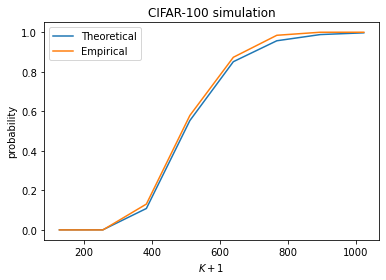

In [9]:
plt.plot(ns, ps, label="Theoretical")
plt.plot(xs, ys, label="Empirical")
plt.ylabel("probability")
plt.xlabel("$K+1$")
plt.title("CIFAR-100 simulation")
plt.legend()